In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
import keras
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding
from keras.models import load_model
from keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
sequence_length=10
min_word_frequency=10
step=1
batch_size=256

**Shuffle and split training set**

In [4]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [5]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length), dtype=np.int32)
    y=np.zeros((batch_size), dtype=np.int32)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t]=word_indices[w]
      y[i]=word_indices[next_word_list[index%len(sentence_list)]]
      index+=1                                             
    yield x, y

**Write generated vocabulary to a file**

In [6]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [7]:
def get_model(dropout=0.35):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=1024))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(512)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(LeakyReLU(alpha=0.1))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words), activation='relu'))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [8]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [9]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length))
      for t, word in enumerate(sentence):
        x_pred[0, t]= word_indices[word]
      ##print("Generating predictions...")
      preds=model.predict(x_pred, verbose=0)[0]
      #print("Done!")
      #print("Generating next index...")
      next_index=sample(preds, diversity)
      #print("Done!")
      #print("Generating next word...")
      next_word=indices_word[next_index]
      #print("Done!")
      #print("Updating sentence value...")
      sentence=sentence[1:]
      #print("Done!")
      #print("Appending to sentence...")
      sentence.append(next_word)
      #print("Done!!!!!!!!!")
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Lee Child**

In [11]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Lee Child.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_lee_child.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_lee_child.txt'

In [12]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints')

In [13]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 11690221


In [14]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 2128031


In [15]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [16]:
len(word_freq)

86092

In [17]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [18]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 86092
Unique words after ignoring: 13119


In [19]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [20]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [21]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  1182558
Remaning sentences:  945463
Number of words:  945463


In [22]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 926553
Size of test set= 18910


In [23]:
model=get_model()

Build model...
Done!


In [24]:
#lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)
#optimizer=keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

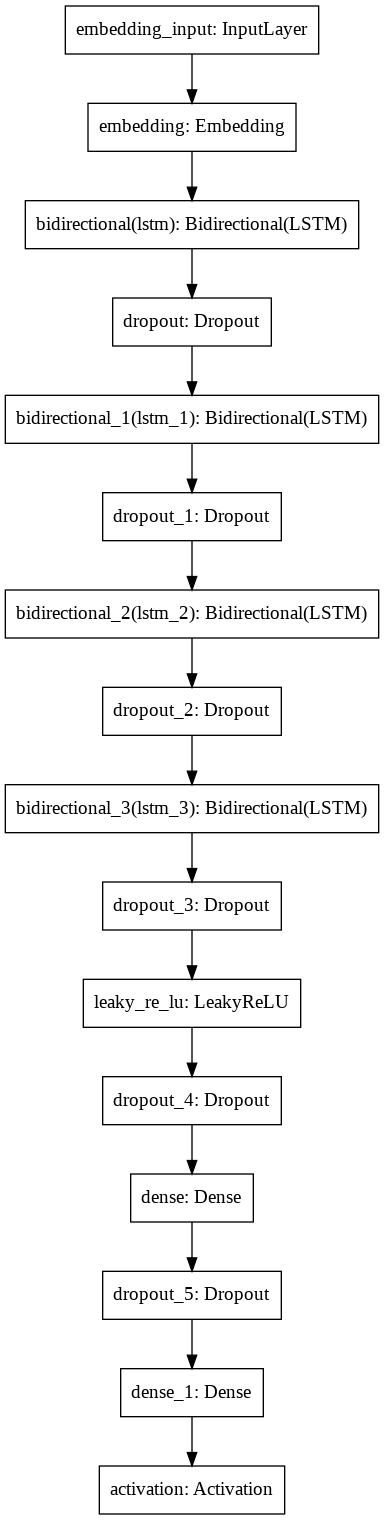

In [25]:
plot_model(model, to_file='Lee Child model.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1024)        13433856  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1024)        6295552   
_________________________________________________________________
dropout (Dropout)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 1024)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 1024)        0

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
int(len(sentences_test)/batch_size)+1

74

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=10, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/model_lee_child.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_lee_child.h5")
print("Saved model to disk!")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
3620/3620 [==============================] - 1261s 337ms/step - loss: 6.2955 - accuracy: 0.1129 - val_loss: 5.3458 - val_accuracy: 0.1704


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch001-words13119-sequence10-minfreq10-loss5.8413-accuracy0.1405-val_loss5.3458-val_accuracy0.1704/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch001-words13119-sequence10-minfreq10-loss5.8413-accuracy0.1405-val_loss5.3458-val_accuracy0.1704/assets


Epoch 2/10
3620/3620 [==============================] - 1234s 341ms/step - loss: 5.2560 - accuracy: 0.1705 - val_loss: 5.1053 - val_accuracy: 0.1854


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch002-words13119-sequence10-minfreq10-loss5.1829-accuracy0.1754-val_loss5.1053-val_accuracy0.1854/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch002-words13119-sequence10-minfreq10-loss5.1829-accuracy0.1754-val_loss5.1053-val_accuracy0.1854/assets


Epoch 3/10
3620/3620 [==============================] - 1245s 344ms/step - loss: 4.9882 - accuracy: 0.1852 - val_loss: 4.9916 - val_accuracy: 0.1944


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch003-words13119-sequence10-minfreq10-loss4.9475-accuracy0.1883-val_loss4.9916-val_accuracy0.1944/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch003-words13119-sequence10-minfreq10-loss4.9475-accuracy0.1883-val_loss4.9916-val_accuracy0.1944/assets


Epoch 4/10
3620/3620 [==============================] - 1245s 344ms/step - loss: 4.8037 - accuracy: 0.1950 - val_loss: 4.9274 - val_accuracy: 0.1975


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch004-words13119-sequence10-minfreq10-loss4.7750-accuracy0.1977-val_loss4.9274-val_accuracy0.1975/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch004-words13119-sequence10-minfreq10-loss4.7750-accuracy0.1977-val_loss4.9274-val_accuracy0.1975/assets


Epoch 5/10
3620/3620 [==============================] - 1241s 343ms/step - loss: 4.6566 - accuracy: 0.2030 - val_loss: 4.8909 - val_accuracy: 0.2034


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch005-words13119-sequence10-minfreq10-loss4.6377-accuracy0.2056-val_loss4.8909-val_accuracy0.2034/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch005-words13119-sequence10-minfreq10-loss4.6377-accuracy0.2056-val_loss4.8909-val_accuracy0.2034/assets


Epoch 6/10
3620/3620 [==============================] - 1243s 343ms/step - loss: 4.5358 - accuracy: 0.2106 - val_loss: 4.8723 - val_accuracy: 0.2081


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch006-words13119-sequence10-minfreq10-loss4.5218-accuracy0.2129-val_loss4.8723-val_accuracy0.2081/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch006-words13119-sequence10-minfreq10-loss4.5218-accuracy0.2129-val_loss4.8723-val_accuracy0.2081/assets


Epoch 7/10
3620/3620 [==============================] - 1245s 344ms/step - loss: 4.4306 - accuracy: 0.2158 - val_loss: 4.8846 - val_accuracy: 0.2091


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch007-words13119-sequence10-minfreq10-loss4.4207-accuracy0.2184-val_loss4.8846-val_accuracy0.2091/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch007-words13119-sequence10-minfreq10-loss4.4207-accuracy0.2184-val_loss4.8846-val_accuracy0.2091/assets


Epoch 8/10
3620/3620 [==============================] - 1244s 344ms/step - loss: 4.3334 - accuracy: 0.2222 - val_loss: 4.8833 - val_accuracy: 0.2081
Epoch 9/10
3620/3620 [==============================] - 1235s 341ms/step - loss: 4.2522 - accuracy: 0.2276 - val_loss: 4.9097 - val_accuracy: 0.2110


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch009-words13119-sequence10-minfreq10-loss4.2503-accuracy0.2296-val_loss4.9097-val_accuracy0.2110/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch009-words13119-sequence10-minfreq10-loss4.2503-accuracy0.2296-val_loss4.9097-val_accuracy0.2110/assets


Epoch 10/10
3620/3620 [==============================] - 1242s 343ms/step - loss: 4.1746 - accuracy: 0.2331 - val_loss: 4.9264 - val_accuracy: 0.2101
Saved model to disk!


In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/model_lee_child.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/model_lee_child.h5")
print("Saved model to disk!")

Saved model to disk!


In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/checkpoints/METG-epoch001-words13119-sequence10-minfreq10-loss5.8413-accuracy0.1405-val_loss5.3458-val_accuracy0.1704"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
##model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Lee Child/model_lee_child.h5")

**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length))
    for t, word in enumerate(sentence):
      x_pred[0, t]= word_indices[word]
    ##print("Generating predictions...")
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
##vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_lee_child.txt"

In [ ]:
##model=load_model(model_file)
##vocabulary=open(vocabulary_file, "r").readlines()
##print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
#word_indices=dict((c, i) for i, c in enumerate(words))
#indices_word=dict((i, c) for i, c in enumerate(words))

For generating essays with 250 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=250
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Lee Child/", 
                True, "Lee Child")
  print("=====================================================")

Seed sentence: a miniature version of andrew peterson. his face was equal
====Generating text====
Diversity:  0.3
Seed sentence: a miniature version of andrew peterson. his face was equal
a miniature version of andrew peterson. his face was equal equal of a big task. the guy was staring at
 him and his face was still still in the air.
 he was carrying a pair of paper in his pocket
 and a gun on his hands and his weight. he
 heard the door open and hit the door and the
 clock in my head and

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


 the guy in the suit
 said, ‘i don’t like the mp unit in the world.
 i think the old guy was a little in the
 world. he was wearing a black shirt. no sound in
 his eyes. no sign of it. no sound at all.
 no sign of it. no windows. no sign of it.
 no sign of a big man in a hurry. it
 was a little more than a mile away from the
 highway. the guy in the door was a big guy
 who had a big guy in a decent lot. he
 was a big man, and he was in a hurry.
 the truck was a big sedan and the door opened.
 the woman said, ‘put the transmission in the window and
 get the phone back to the back of the office
 and sat down in the dark and glanced at the
 guy in the face. the guy in the suit said,
 ‘i want to get a look at the situation. so
 i need to know what you are. i don’t know,"
 he said. "i don't know. i don't know." "but i
 don't think you are. i don’t know," he said. "i


Writing to file...Done!
====Generating text====
Diversity:  0.4
Seed sentence: a miniature version of andrew peterson. his f

For generating a small essay of 300 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Lee Child/", 
                True, "Lee Child")
  print("=====================================================")

Seed sentence: said. "i'm going to hang up now. you make that
====Generating text====
Diversity:  0.3
Seed sentence: said. "i'm going to hang up now. you make that
said. "i'm going to hang up now. you make that that call out of the car and get a cup
 of paper in front of the car and the guy
 in the suit and the clock in his head was
 a long pause. he was in a small silence. she
 was already in a car on the ground, looking at
 the map. the guy who had been in the house
 was a lot of time." "i don't know." "i don’t
 know. i don’t want to see that piece of luck,
 but i don’t like to tell me about the same
 thing. i think i was going to be a million
 dollars in the world, and it was a big target.
 i was a big man of the same result. the
 guy with the chain was in the air. the door
 was still open and the engine was still open. the
 air was still warm. the air was dark and silent.
 the lights were still open. the windows were still bright.
 it was a big woman in a pair of blood
 in a shallo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


 for the small hour.
 close enough to fit back. right-handed. he assumed they were


Writing to file...Done!
====Generating text====
Diversity:  1.0000000000000002
Seed sentence: said. "i'm going to hang up now. you make that
said. "i'm going to hang up now. you make that that a few grand trying to rely on the seven
 shoe of her boots, for about an all-purpose effort and
 then she listened to his mother, toward the quiet old
 problem. pushed the bubble side where the plant, hustled through
 the bridge to the way he had dressed there, in
 the crossroads he could feel the guy on the left
 again on the line. there was nobody in my head:
 some kind of a scrap plastic face. duffy was looking
 for more than he would be doing something, too. apart
 from all four tried and dressed, her before, and partly
 on her stomach. 'you don't want to see." reacher stacked
 the bills down again and raised her ear to him
 with his top foot down to his left into the
 moonlight. johnson gasped once and stepp

For generating novels with 10000 words

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10000
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Lee Child/", 
                True, "Lee Child")
  print("=====================================================")

Seed sentence: shift in an old car and the gun twisted awkwardly
====Generating text====
Diversity:  0.3
Seed sentence: shift in an old car and the gun twisted awkwardly
shift in an old car and the gun twisted awkwardly awkwardly in the back seat and looked at the doctor
 and asked, ‘i need to know where he is, and
 i don't want to do it for you. you can
 see the first thing with the first thing in the
 world in the world. the guy in the place was
 a long way from the diner. he was a good
 man, and he had a big woman in a big
 leather shirt. he was wearing a black shirt and a
 black shirt. not a big guy. he was still in
 the silence at the end of the house. the two
 men and the tires were still in the air. the
 road was still silent. it was a big black green
 sedan that was a small red item in the middle
 of the city. he saw the old guy in the
 back seat. he was a little tired. he was looking
 at the office and the third guy in the direction
 had a little more to be, and then the burea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
 the family will have a young guy in a hurry
 called goodman and i just took the way off the
 right-hand door and put the hammer down again and swiveled
 the green shotgun and stepped out. he reached up and
 tilted his head around the track of the basement door
 and opened the door and headed back to the kitchen.
 the first guy was in the room a blank tree.
 two of them, and a decent silence. he heard nothing.
 his heart was loud. he was still in the shadow
 of the turn. he was staring back at her gun.
 he was in a vacant lot in a suit and
 a restless guard behind him. "this is the kind of
 thing you do to and we can’t come after you,
 right?" froelich said. "why do you know how we should
 go to him, right? we’ll go back to the hoover
 building and the united states. the rest of the guy.
 they were smiling in the mirror of panic. he was
 still very carefully, like she was through the church with
 a smell of stale house and tires and fu

For generating novels with 10500 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Lee Child/", True, "Lee Child")
  print("=====================================================")

Seed sentence: and the missing beretta and the message on the hallway
====Generating text====
Diversity:  0.3
Seed sentence: and the missing beretta and the message on the hallway
and the missing beretta and the message on the hallway hallway and the back of the driver’s seat. the guy
 in the desk was staring at her. she was wearing
 a black shirt. her hair was still still hot. her
 eyes were dark. she was wearing a black leather shirt.
 her eyes were closed. she was in the direction of
 the world. she was a big guy. a little big.
 the guy was a big guy, and he was a
 big guy for a couple of hours and he was
 a lot more than a hundred miles away, but it
 was a little like a gun in the shadows. the
 air was still empty. just a big black white sedan
 and a black shirt on the sofa. a small dark
 car, a black black leather shirt on a low plastic
 bar and a black shirt and a black leather bag.
 the waitress was a small place, but he was a
 little puzzled. it was a little old and the first
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
 and they didn't do that i had been out there
 before. the ocean was the same thing as wide and
 heavy as a tiny woman who had waited a long
 time. the guy said, ‘ok, you go out to the
 last day of the station house and parked it talking
 and sat down, and then he was a little tense.
 and he was going to show me for a long
 time. i spent a few minutes inside the gap between
 them and the glare of the bottom of the dakota
 was a woman for a spell, and then he nodded
 again. "this is the guy like that. and i need
 to go to his position because you're a lot happier
 than we should get a new fax on the list.
 i was a little clear of the railroad and a
 hundred yards from the front. i was working out the
 book from the sleeping report. i saw a gun on
 a dirty area in the other direction. the pilot was
 a new guy. big hair. a little dressed in a
 hurry. a big hum full of green. the furniture was
 fitted on the wheel for the first couple of d